#Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=c3574b937e8855f408e53471e9b21aa692a967a221713450c239abb414cee0cb
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=afa012a057c8d2b55e5a5c073b7465985dc35e7a943e3d8d0a35f003dbbfae76
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411 (from 1)
Receiving objects: 100% (411/411), 851.74 MiB | 17.46 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [35]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper


#2 Setup Configurations

In [6]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [13]:
idx = 10
row = df.iloc[idx]
image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255

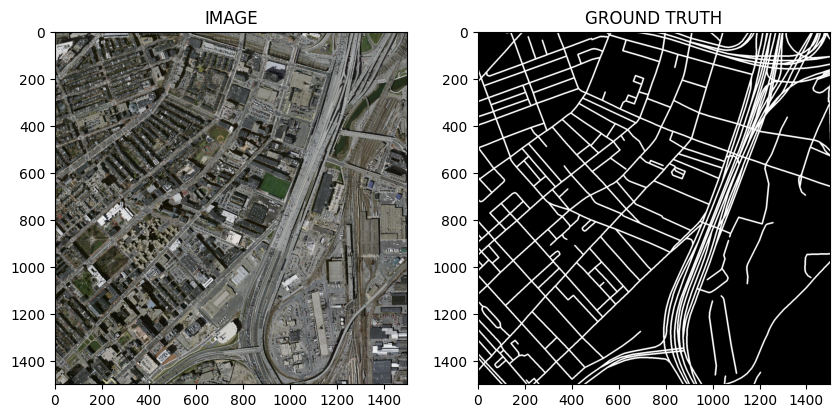

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [15]:
train_df , val_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [16]:
len(train_df)

159

In [17]:
len(val_df)

40

#3 : Augmentation Functions

In [18]:
import albumentations as A

In [20]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])
def get_vlaid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

#4 : Create Custom Dataset

In [22]:
from torch.utils.data import Dataset

In [59]:
class segmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    row = df.iloc[idx]
    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  #(h,w)
    mask = np.expand_dims(mask , axis = -1) #(h, w, c)
    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image'] #(h,w,c)
      mask = data['mask']
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.5
    mask = torch.round(torch.Tensor(mask)/ 255.0)

    return image, mask

In [60]:
trainset = segmentationDataset(train_df, get_train_augs())
valset = segmentationDataset(val_df, get_vlaid_augs())

In [61]:
print(f'There are {len(trainset)} images in the trainset')
print(f'There are {len(valset)} images in the valset')

There are 159 images in the trainset
There are 40 images in the valset


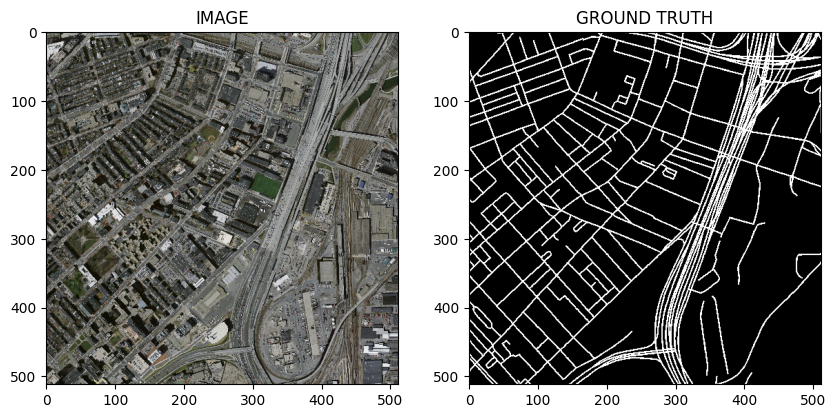

In [62]:
inx = 45
image, mask = valset[idx]
helper.show_image(image, mask)

#5 : Load dataset into batches

In [63]:
from torch.utils.data import DataLoader

In [64]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
valloader = DataLoader(valset, batch_size = BATCH_SIZE)

In [65]:
print(f'There are {len(trainloader)} batches in the trainloader')
print(f'There are {len(valloader)} batches in the valloader')

There are 20 batches in the trainloader
There are 5 batches in the valloader


In [67]:
for images , masks in trainloader:
  print(f'one batch of images has a shape of : {images.shape}')
  print(f'one batch of masks has a shape of : {masks.shape}')
  break

one batch of images has a shape of : torch.Size([8, 3, 512, 512])
one batch of masks has a shape of : torch.Size([8, 1, 512, 512])


#6 : Create Segmentation Model

In [68]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch import nn

In [70]:
class segmentationModel(nn.Module):
  def __init__(self):
    super(segmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self, images, masks = None):
    logits = self.backbone(images)
    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)
    return logits

In [74]:
model = segmentationModel()
model.to(DEVICE);

#7 : Create Train and Validation Function

In [84]:
def train_fn(dataloader, model, optimizer):
  model.train() # trun ON dropout , batchnorm , etc
  total_loss = 0
  # Use dataloader instead of loader in tqdm function
  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/len(dataloader)

In [87]:
def eval_fn(dataloader, model):
  model.eval() # trun OFF dropout , batchnorm , etc
  total_loss = 0
  with torch.no_grad():

    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()

    return total_loss/len(dataloader)

#8 : Train Model

In [79]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [88]:
best_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  val_loss = eval_fn(valloader, model)

  if val_loss < best_loss:
    torch.save(model.state_dict(), 'best_model.pth')
    print("saved model")
    best_loss = val_loss
  print(f'epoch : {i+1} train_loss : {train_loss} val_loss : {val_loss}')

100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


saved model
epoch : 1 train_loss : 0.7267835080623627 val_loss : 0.7872913122177124


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


saved model
epoch : 2 train_loss : 0.6912248760461808 val_loss : 0.7024591445922852


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


saved model
epoch : 3 train_loss : 0.6810115277767181 val_loss : 0.6938622117042541


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


saved model
epoch : 4 train_loss : 0.6655925512313843 val_loss : 0.6446022152900696


100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


saved model
epoch : 5 train_loss : 0.6541594505310059 val_loss : 0.6279419600963593


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


saved model
epoch : 6 train_loss : 0.6298320949077606 val_loss : 0.626578414440155


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


epoch : 7 train_loss : 0.6331210166215897 val_loss : 0.6642430543899536


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


epoch : 8 train_loss : 0.6300863131880761 val_loss : 0.6496381878852844


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


saved model
epoch : 9 train_loss : 0.626189611852169 val_loss : 0.6213319897651672


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


saved model
epoch : 10 train_loss : 0.6370791643857956 val_loss : 0.6183598756790161


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


saved model
epoch : 11 train_loss : 0.6261779651045799 val_loss : 0.5944875955581665


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


epoch : 12 train_loss : 0.6129393547773361 val_loss : 0.6024321556091309


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


saved model
epoch : 13 train_loss : 0.6067200839519501 val_loss : 0.581467354297638


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


saved model
epoch : 14 train_loss : 0.5947234258055687 val_loss : 0.5468878626823426


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


epoch : 15 train_loss : 0.605073107779026 val_loss : 0.6425625443458557


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


epoch : 16 train_loss : 0.6130239024758339 val_loss : 0.5858905732631683


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


epoch : 17 train_loss : 0.5932456880807877 val_loss : 0.5951952278614044


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


epoch : 18 train_loss : 0.577695544064045 val_loss : 0.5515653729438782


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


saved model
epoch : 19 train_loss : 0.5783549875020981 val_loss : 0.5444904744625092


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


epoch : 20 train_loss : 0.5778639912605286 val_loss : 0.5750032246112824


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


epoch : 21 train_loss : 0.5711986497044563 val_loss : 0.5632054686546326


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


saved model
epoch : 22 train_loss : 0.5664688989520072 val_loss : 0.5388965606689453


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


saved model
epoch : 23 train_loss : 0.5833057224750519 val_loss : 0.5343365252017975


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


epoch : 24 train_loss : 0.568887734413147 val_loss : 0.5625793159008026


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

epoch : 25 train_loss : 0.5663321986794472 val_loss : 0.5670004189014435


#9 : Inference

In [96]:
idx = 30
model.load_state_dict(torch.load('/content/best_model.pth'))
image, mask = valset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))  #(c,h,w), -> ((b,c,h,w))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

<ipython-input-96-6f3c53a50953>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pth'))


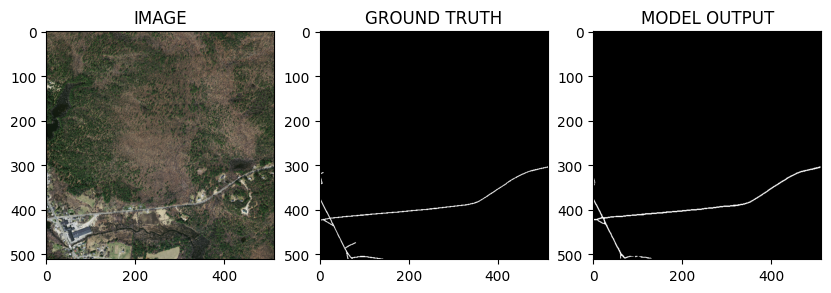

In [97]:
helper.show_image (image,mask, pred_mask.detach().cpu().squeeze(0))